# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
FILTERS = '"#$%&()*+/:;=@[\\]^_`{|}~\t\n'

In [8]:
[i for i in range(3)]

[0, 1, 2]

In [9]:
# MAX_SEQ_LEN = 150
def proc_sentences(df, col_sentence, col_targ):
    sentences = []
#     li_mask_LH = []
#     li_mask_RH = []
    li_mask_cntx = []
    li_mask_targ = []
#     li_targ = []
#     li_targ_idx = []
    li_sent_len = []
    li_sent_pad = []
    for i in range(df.shape[0]):
        sent = df.iloc[i][col_sentence]
        
        targ = None
        if(col_targ):
            targ = df.iloc[i][col_targ]
        else:
            targ = "<UNK>"
        
        sent = sent.replace("______", targ)
        sent = sent.replace("<BOS>", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace(",?", " ?").replace("'s", " 's")
        sent_tok = text_to_word_sequence(sent, lower=False, filters=FILTERS)
        sent_pad = pad_sequences([sent_tok], maxlen=MAX_SEQ_LEN, dtype='object', padding='post', value=[""])       
        targ_idx = np.where(targ==sent_pad[0])[0][0]
        
        mask_targ = [0]*(MAX_SEQ_LEN)
        mask_targ[targ_idx] = 1
#         mask_LH = [0]*(MAX_SEQ_LEN)
#         mask_RH = [0]*(MAX_SEQ_LEN)
        mask_cntx = [0]*(MAX_SEQ_LEN)
        for i in range(targ_idx):
            mask_cntx[i] = 1
        if(col_targ):
            for i in range(targ_idx, len(sent_tok)):
                mask_cntx[i] = 1
        else:
            for i in range(targ_idx+1, len(sent_tok)):
                mask_cntx[i] = 1
    
#         for i in range(targ_idx):
#             mask_LH[i] = 1
#         for i in range(targ_idx+1, len(sent_tok)):
#             mask_RH[i] = 1
        
        sent_len = len(sent_tok)
        
#         li_targ.append(targ)
#         li_targ_idx.append(targ_idx)
        li_sent_len.append(sent_len)
        li_sent_pad.append(list(sent_pad)[0])
        li_mask_cntx.append(mask_cntx)
        li_mask_targ.append(mask_targ)
#         li_mask_LH.append(mask_LH)
#         li_mask_RH.append(mask_RH)
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad), np.array(li_targ)]
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad)]
#     sentences = [np.array(li_sent_len), np.array(li_sent_pad), # np.array(li_targ_idx),
#                  np.array(li_mask_LH), np.array(li_mask_RH)] #, np.sum((li_mask_LH, li_mask_RH), axis=0)]
    sentences = [np.array(li_sent_len), np.array(li_sent_pad), np.array(li_mask_cntx), np.array(li_mask_targ)]
    return(sentences)

In [10]:
sentences_wttarg = proc_sentences(df_cloze, 'sentence', 'syn1')
sentences_notarg = proc_sentences(df_cloze, 'sentence', None)

In [11]:
# import pickle
# with open("dscovar_sentences_wttarg_elmo_max150.pickle", "wb") as f: pickle.dump(sentences_wttarg, f)
# with open("dscovar_sentences_notarg_elmo_max150.pickle", "wb") as f: pickle.dump(sentences_notarg, f)

In [12]:
len(sentences_wttarg[1][0])

30

In [13]:
sentences_notarg

[array([11, 11, 12, ..., 14, 12, 16]),
 array([['A', '<UNK>', 'emerged', ..., '', '', ''],
        ['A', 'bohemian', 'is', ..., '', '', ''],
        ['A', 'bunch', 'of', ..., '', '', ''],
        ...,
        ['You', 'will', 'not', ..., '', '', ''],
        ["You'll", 'find', 'what', ..., '', '', ''],
        ['Your', 'plan', "'s", ..., '', '', '']], dtype=object),
 array([[1, 0, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [14]:
df_cloze.columns

Index(['Unnamed: 0', 'index', 'cloze_resp', 'sentID_GM', 'sentence', 'targ',
       'targ_POS', 'cloze_resp_len', 'ent_elmo', 'ent_cloze', 'bert_score',
       'glove_score', 'Unnamed: 0.1', 'sent_idx', 'scores', 'scores_sum',
       'scores_avg', 'scores_std', 'scores_avg_rank', 'elmo_score', 'sent_len',
       'targ_loc', 'targ_loc_before', 'targ_loc_end', 'targ_loc_rel', 'syn1',
       'syn2', 'syn3'],
      dtype='object')

In [15]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_lmo = resp_scores[:, 1]
resp_brt = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
# with open("resp_bws.pickle", "wb") as f: pickle.dump(resp_bws, f)

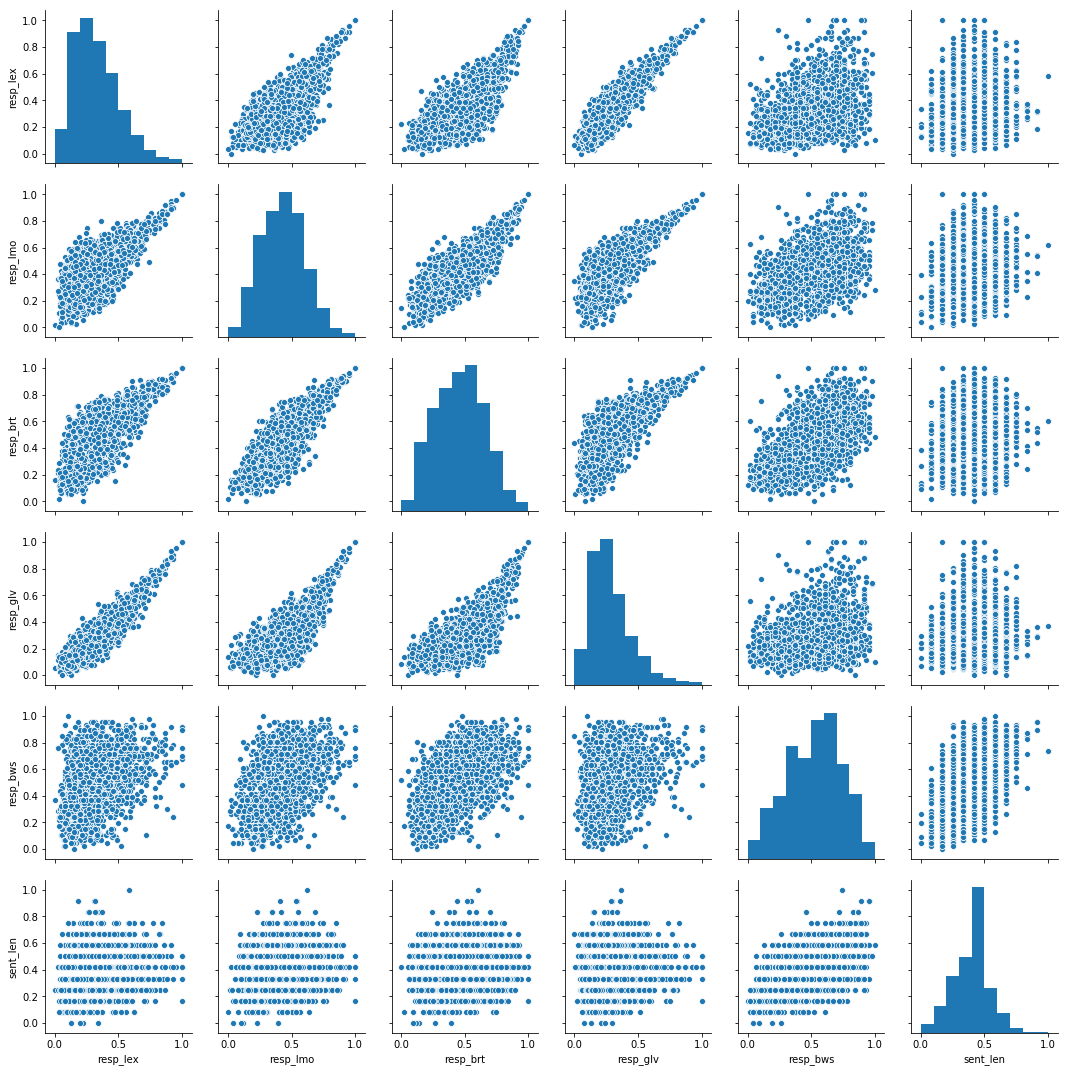

In [17]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

# ELMo + Attention model

## 1emb

In [18]:
K.clear_session()
sess = tf.Session()

model = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

model.summary()

1024
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
elmo_sent_raw (ElmoLayer)       (None, None, 1024)   4           input_sent_len[0][0]             
                                                                 input_sentence[0][0]             
__________________________________________________________________________________________________
input_tloc (InputLayer)         [(None, 30)]         0                                   

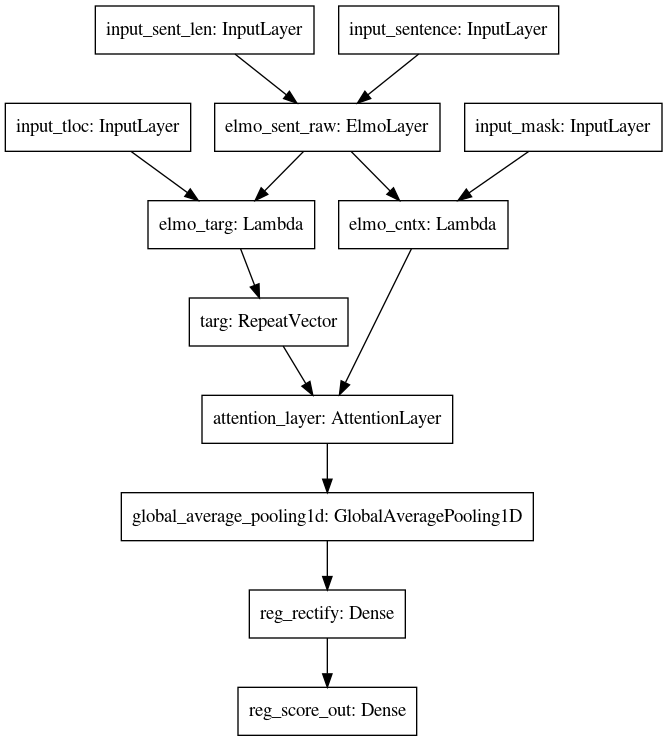

In [19]:
plot_model(model)

## 2emb

In [20]:
K.clear_session()
sess = tf.Session()

model = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=True)
initialize_vars(sess)

model.summary()

1024
1024
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
elmo_targ_raw (ElmoLayer)       (None, None, 1024)   4           input_sent_len[0][0]             
                                                                 input_sentence[0][0]             
__________________________________________________________________________________________________
input_tloc (InputLayer)         [(None, 30)]         0                              

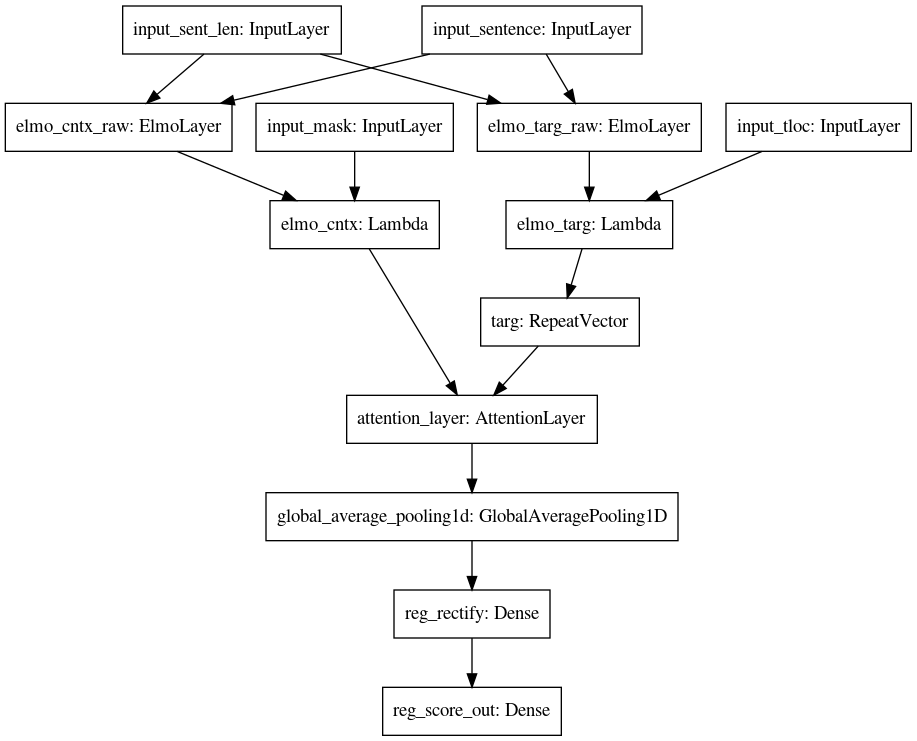

In [21]:
plot_model(model)

# K-fold training and predictions 

In [17]:
# target word location categories
targ_loc_cat = []
for i in range(df_cloze.shape[0]):
    if(df_cloze['targ_loc_end'][i]): 
        targ_loc_cat.append('3_last')
    else:
        if(df_cloze['targ_loc_rel'][i] <= 0.5):
            targ_loc_cat.append('0_less_50')
        elif((df_cloze['targ_loc_rel'][i] > 0.5)&(df_cloze['targ_loc_rel'][i] <= 0.65)):
            targ_loc_cat.append("1_(50_65]")
        elif((df_cloze['targ_loc_rel'][i] > 0.65)):
            targ_loc_cat.append("2_more_65")            

In [18]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [19]:
sent_len_cat = pd.qcut(sent_len, [0, 0.20, 0.40, 0.60, 0.80, 1])
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

In [20]:
# fold settings
gkf1 = GroupKFold(n_splits=K_FOLDS) ## target words
gkf2 = GroupKFold(n_splits=len(Counter(targ_loc_cat))) ## target word locations
gkf3 = GroupKFold(n_splits=len(sent_len_cat.value_counts())) ## sentence length

# Fitted to: BWS 

## fold: target words

In [26]:
X_wttarg = sentences_wttarg
X_notarg = sentences_notarg
y = resp_bws
y_type = 'bws'

## /w attention + finetune ELMo layer weights

In [27]:
NUM_ITER = [2,3,5]
LEARNING_RATE = [1e-3, 1e-4, 1e-5]
BATCH_SIZE = [16, 32]

### 1emb 

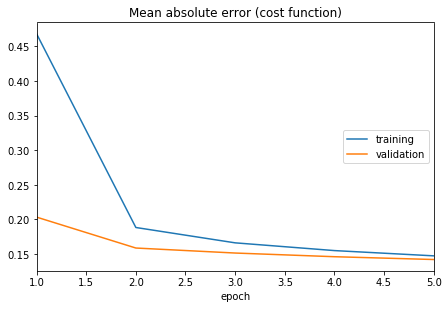

Mean absolute error (cost function):
training   (min:    0.147, max:    0.468, cur:    0.147)
validation (min:    0.142, max:    0.203, cur:    0.142)



In [28]:
# _l_rate = 5e-5
# _num_iter = 3
# _batch_size = 16

for _l_rate in LEARNING_RATE:
    for _batch_size in BATCH_SIZE:
        for _num_iter in NUM_ITER:
            gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])
            train_elmomod_cv(X_notarg, y,
                             gkf_split, True, True, False, 
                             "./model_weights/finetune/elmo/1emb/model_elmo_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             MAX_SEQ_LEN, _l_rate, _num_iter, _batch_size)

### 2emb 

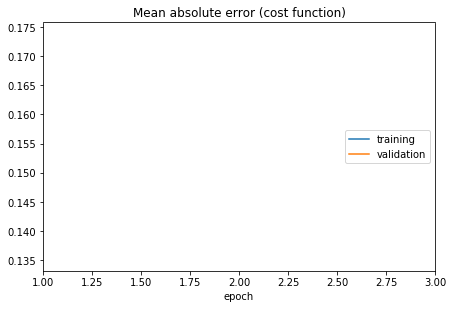

Mean absolute error (cost function):
training   (min:    0.174, max:    0.174, cur:    0.174)
validation (min:    0.135, max:    0.135, cur:    0.135)


In [ ]:
for _l_rate in LEARNING_RATE:
    for _batch_size in BATCH_SIZE:
        for _num_iter in NUM_ITER:
            gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])    
            train_elmomod_cv(X_notarg, y,
                             gkf_split, True, True, True, 
                             "./model_weights/finetune/elmo/2emb/model_elmo_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_"+y_type+"_cvTwrd"+"_i"+str(_num_iter)+"_b"+str(_batch_size)+"_lr"+str(_l_rate),
                             MAX_SEQ_LEN, _l_rate, _num_iter, _batch_size)

# Classification performance 

In [21]:
sent_test_cvTwrd = []
sent_test_cvTloc = []
sent_test_cvSlen = []

sent_test_cvTwrd2 = []
sent_test_cvTloc2 = []
sent_test_cvSlen2 = []

resp_bws_cvTwrd = []
resp_bws_cvTloc = []
resp_bws_cvSlen = []
resp_lex_cvTwrd = []
resp_lex_cvTloc = []
resp_lex_cvSlen = []
resp_lmo_cvTwrd = []
resp_lmo_cvTloc = []
resp_lmo_cvSlen = []


for train_idx, test_idx in gkf1.split(df_cloze['sentence'], groups=df_cloze['targ']):
    sent_test_cvTwrd.append([sent[test_idx] for sent in sentences_wttarg])
    sent_test_cvTwrd2.append([sent[test_idx] for sent in sentences_notarg])
    resp_bws_cvTwrd.append([resp_bws[i] for i in test_idx])
    resp_lmo_cvTwrd.append([resp_lmo[i] for i in test_idx])
    resp_lex_cvTwrd.append([resp_lex[i] for i in test_idx])
    
for train_idx, test_idx in gkf2.split(df_cloze['sentence'], groups=targ_loc_cat):
    sent_test_cvTloc.append([sent[test_idx] for sent in sentences_wttarg])
    sent_test_cvTloc2.append([sent[test_idx] for sent in sentences_notarg])
    resp_bws_cvTloc.append([resp_bws[i] for i in test_idx])
    resp_lmo_cvTloc.append([resp_lmo[i] for i in test_idx])
    resp_lex_cvTloc.append([resp_lex[i] for i in test_idx])
    
for train_idx, test_idx in gkf3.split(df_cloze['sentence'], groups=sent_len_cat):
    sent_test_cvSlen.append([sent[test_idx] for sent in sentences_wttarg])
    sent_test_cvSlen2.append([sent[test_idx] for sent in sentences_notarg])
    resp_bws_cvSlen.append([resp_bws[i] for i in test_idx])
    resp_lmo_cvSlen.append([resp_lmo[i] for i in test_idx])
    resp_lex_cvSlen.append([resp_lex[i] for i in test_idx])    

## CV over target words vs. target word location

In [22]:
Counter(targ_loc_cat)

Counter({'0_less_50': 402, '3_last': 777, '2_more_65': 306, '1_(50_65]': 298})

In [23]:
sent_len_cat.value_counts()

(-0.001, 0.25]    428
(0.25, 0.333]     351
(0.333, 0.417]    343
(0.417, 0.5]      330
(0.5, 1.0]        331
dtype: int64

### fitted to: BWS score
- target location may bias the prediction results in some cases, but not by much
- sentence length may be the problem
- attention layer improve the performance
    - both with/w.o. target word conditions
- NOT including the target word (synonym of the original) improves the performance
- Attention improves the performance
    - attention captures: the relationship between the target (known or unknown) and context

Text(0.5,1,'iter: 2; batch: 16')

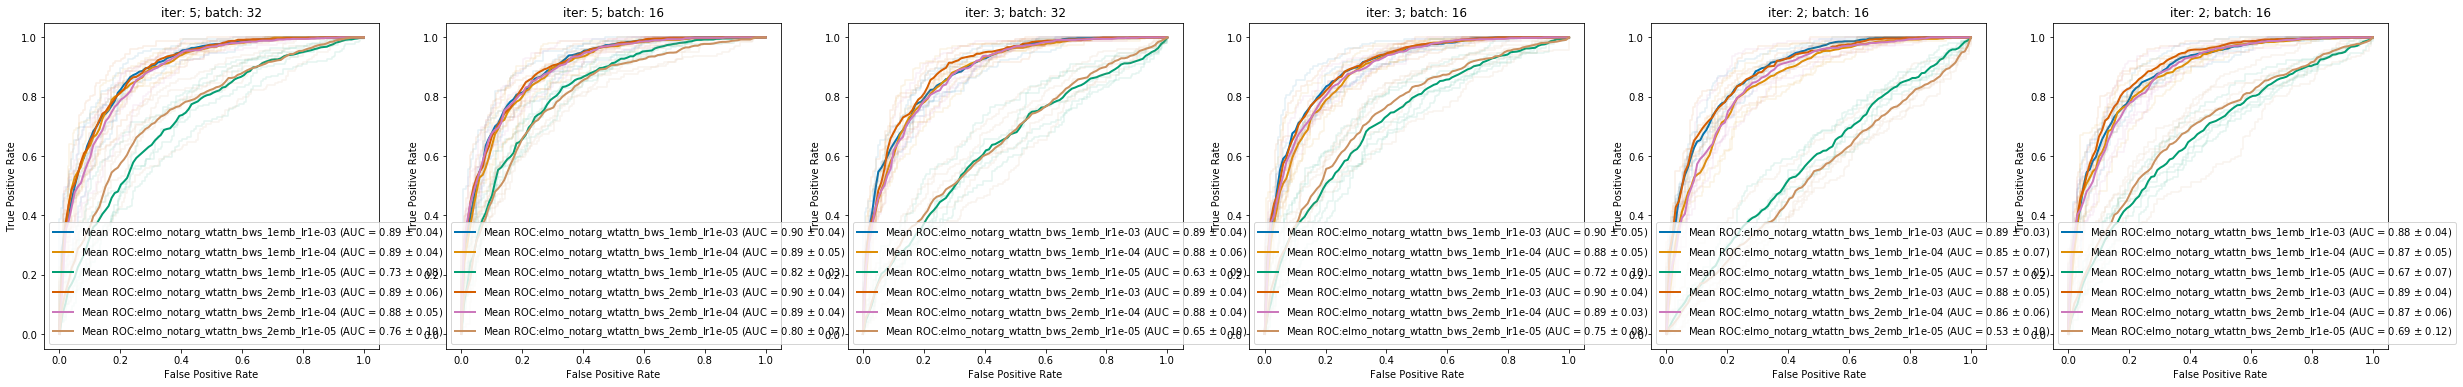

In [24]:
fig, axes = plt.subplots(ncols=6, figsize=(42, 6))
tt_col = sns.color_palette("colorblind", 6)

# iter: 5; batch: 32
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[0], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[0], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[0], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[0], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[0], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[0], tt_col[5], '-')

# iter: 5; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[1], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[1], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[1], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[1], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[1], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i5_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[1], tt_col[5], '-')

# iter: 3; batch: 32
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[2], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[2], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[2], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[2], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[2], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[2], tt_col[5], '-')

# iter: 3; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[3], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[3], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[3], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[3], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[3], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i3_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[3], tt_col[5], '-')

# iter: 2; batch: 32
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[4], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[4], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[4], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[4], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[4], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b32_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[4], tt_col[5], '-')

# iter: 2; batch: 16
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.001*",  "elmo_notarg_wtattn_bws_1emb_lr1e-03", 0.50, "high", fig, axes[5], tt_col[0], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.0001*", "elmo_notarg_wtattn_bws_1emb_lr1e-04", 0.50, "high", fig, axes[5], tt_col[1], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/1emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_1emb_lr1e-05", 0.50, "high", fig, axes[5], tt_col[2], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.001*",  "elmo_notarg_wtattn_bws_2emb_lr1e-03", 0.50, "high", fig, axes[5], tt_col[3], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr0.0001*", "elmo_notarg_wtattn_bws_2emb_lr1e-04", 0.50, "high", fig, axes[5], tt_col[4], '-')
roc_cv_plot(resp_bws_cvTwrd, "./model_predict/finetune/elmo/2emb/preds_elmo_notarg_wtattn_bws_cvTwrd_i2_b16_lr1e-05*",  "elmo_notarg_wtattn_bws_2emb_lr1e-05", 0.50, "high", fig, axes[5], tt_col[5], '-')


axes[0].set_title("iter: 5; batch: 32")
axes[1].set_title("iter: 5; batch: 16")
axes[2].set_title("iter: 3; batch: 32")
axes[3].set_title("iter: 3; batch: 16")
axes[4].set_title("iter: 2; batch: 16")
axes[5].set_title("iter: 2; batch: 16")